# ***Computer Vision Final Project: Breast Cancer Tumor Classification***
## Section 1 Spring 2023
### Nicholas Lee, Nic Brathwaite, Amir Moayed

<a href="https://colab.research.google.com/github/NickBrath/Computer-Vision-281-Final-Project/blob/main/Nick_Lee_Baseline_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Possible features of benign tumors to look for in images: 
histologically benign [1]
	(adjective) Referring to a lesion that does not meet any criteria of malignancy – e.g., marked cellular atypia, mitosis, disruption of basement membranes, metastasize.

Consuming TFRecord data
Refer to the Loading TFRecords tutorial for an end-to-end example.

The tf.data API supports a variety of file formats so that you can process large datasets that do not fit in memory. For example, the TFRecord file format is a simple record-oriented binary format that many TensorFlow applications use for training data. The tf.data.TFRecordDataset class enables you to stream over the contents of one or more TFRecord files as part of an input pipeline.

# Setup

In [1]:
# Google packages
# from google.colab import drive
# from google.colab import files
# from google.colab.patches import cv2_imshow

# Mount google drive
# drive.mount('/content/drive')

In [2]:
# base packages
import os
import warnings
import random
from datetime import date
import re
from tqdm.notebook import tqdm  # progress bar library
import glob

# DS packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# image packages
import PIL
import urllib
import cv2
from skimage.color import rgb2gray
import skimage.io as skio

# ML packages
import scipy as sc
import sklearn as sk
import tensorflow as tf

%matplotlib inline


In [3]:
# import tomopy
import mkl
# Intel(R) MKL FFT functions to run sequentially
mkl.domain_set_num_threads(1, domain='fft')


'success'

In [4]:
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

In [5]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.config.list_physical_devices('GPU')

## Functions

In [6]:
# pickle object for later
import pickle

def pickler(ob, pklFileName):
    """ 
      Create pickle object to load later or in different environments for use later

      ob: object, python object intended to pickle
      pklFileName: string, name of the pickle file e.g. "User/content/drive/209/ThisDataFrame.pkl"
    """

    with open(pklFileName, "wb+") as f:
        pickle.dump(ob, f)


def load_pickles(pklFilePath):
    """
      path: string, path to object
      pklFileName: string, pickle file name with extension .pkl
    """

    return pd.read_pickle(pklFilePath)


In [7]:
import time

def timeis(func):
    """Decorator that reports the execution time."""

    def wrap(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()

        print(func.__name__, end-start)
        return result
    return wrap

## File Paths

In [8]:
# Paths
main_path = "G:\\My Drive\\"

project_path = "w281_final_project"
project_path = os.path.join(main_path, project_path)

datadir = os.path.join(project_path, "Data")

save_path = "".join([date.today().strftime('%Y%m%d'), "_baseline_models/"])
save_path = "".join([project_path, save_path])

# Sanity Check
print("project path: ", project_path)
print("Data directory", datadir)
print("save path: ", save_path)


project path:  G:\My Drive\w281_final_project
Data directory G:\My Drive\w281_final_project\Data
save path:  G:\My Drive\w281_final_project20230408_baseline_models/


## Load tensorflow dataset to use in models

In [9]:
# load metadata information for full paths and annotations
df = load_pickles(os.path.join(datadir, "pickles\metaData.pkl"))

# starting with 40x
df.query('MAGNIFICATION == "40"').reset_index(inplace=True, drop=True)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   BIOPSY_PROCEDURE  7909 non-null   object
 1   TUMOR_CLASS       7909 non-null   object
 2   TUMOR_TYPE        7909 non-null   object
 3   YEAR              7909 non-null   object
 4   SLIDE_ID          7909 non-null   object
 5   MAGNIFICATION     7909 non-null   object
 6   SEQ               7909 non-null   object
 7   FULL_PATH         7909 non-null   object
 8   BASE_NAME         7909 non-null   object
dtypes: object(9)
memory usage: 556.2+ KB


,BIOPSY_PROCEDURE,TUMOR_CLASS,TUMOR_TYPE,YEAR,SLIDE_ID,MAGNIFICATION,SEQ,FULL_PATH,BASE_NAME
0,SOB,B,A,14,22549AB,100,004,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-004.png
1,SOB,B,A,14,22549AB,100,002,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-002.png
2,SOB,B,A,14,22549AB,100,003,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-003.png
3,SOB,B,A,14,22549AB,100,001,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-001.png
4,SOB,B,A,14,22549AB,100,007,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-007.png


In [10]:
# swap beginning path from google drive to local computer path
pattern = "/content/drive/MyDrive/"
replacement = "G:/My Drive/"

df['FULL_PATH'] = df['FULL_PATH'].str.replace(pattern, replacement)

# Quick EDA

<Axes: ylabel='count'>

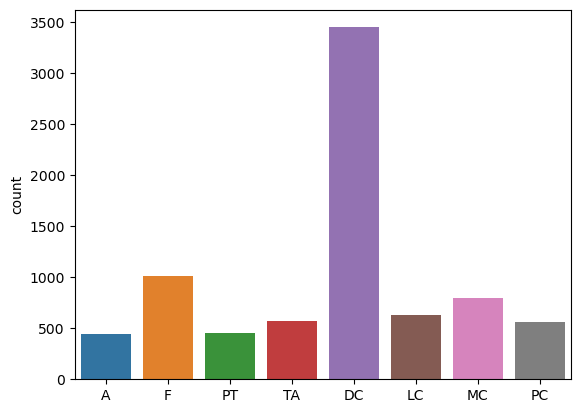

In [11]:
# check distribution of labels
sns.countplot(x=df['TUMOR_TYPE'].values)

DC is by far the most prevelant in the dataset

### Examples of images

Text(0.5, 0.98, 'Sample of images in dataset')

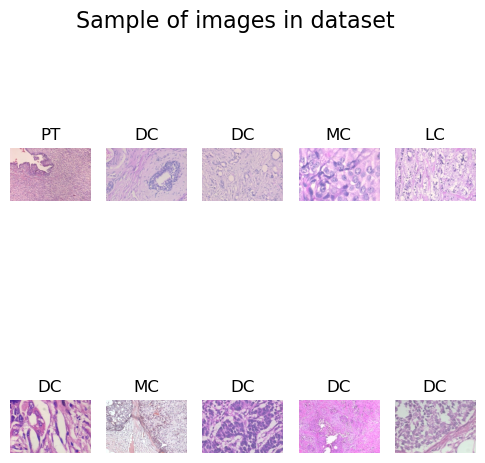

In [12]:
# Examples of images
df_temp = df.sample(10).reset_index(drop=True)

nrows = 2
ncols = 5

fig, axs = plt.subplots(nrows, ncols, figsize=(6, 6))

# Flatten axes to make it easier to access
axs = axs.flatten()

for i, file in enumerate(df_temp['FULL_PATH']):
    #read in file
    pic = plt.imread(file)

    # add image to axes
    axs[i].imshow(pic)

    # drop axis labels
    axs[i].axis('off')
    # add axes title
    axs[i].set(title=df_temp.loc[i, 'TUMOR_TYPE'])

fig.suptitle("Sample of images in dataset", fontsize=16)


Typically a trained histologist would evalulate the staining of each slide and rank them from 1-5 based on their own criteria. This provides issues when compariing tissues sections from different patients and labs. Processing the tissues and staining with hematoxylin and eosin can cause different artifcats to be present in the slides. Additional variations can come from image capture procedures. Luckily in this dataset the data curators used the same equipment and settings (*fact check please*). Regardless, it may be beneficial to normalize for brightness or intensity of colors. Initially our approach will be to use only grey scale images. 

There are also gaps in some of the tissue that cause the area size to vary between slides. 
Orientation could also be a challenge. The tissue is not always oriented the same way to the view of the tissue can change depending on how the parafin was sectioned and laid on a slide. 

There are substructures within the images that histologist normally use to annotate these images. These features are important because the types of tissues that the cancer is affecting will change the appearance of the slide and staining profile. Understanding the effected cellular structures also helps to lead to diagnosises in the clinic. It would be interesting in future work to use this set to see what structures are effected by different types of cancer. 

# Creating dataset

More about [batched datasets](https://www.tensorflow.org/guide/data#batching_dataset_elements) can be found there.

In [13]:
def create_tf_ds(file_paths, labels):
    """ Create tensorflow dataset from file paths and labels """
    # create dataset
    ds = tf.data.Dataset.from_tensor_slices(
        (file_paths, labels))  # mapping like a zip in python

    return ds


def read_image(image_file_path, label):
    """Function to read in images to create tf dataset"""
    
    image = tf.io.read_file(image_file_path)  # read in image
    
    # preserving RGB colors with channels = 3. Reads array
    image = tf.image.decode_image(image, channels=3, dtype=tf.float32)

    return image, label


## Image Augmentation

- [] Image Sharpening
- [] Contrast
- [] GrayScale
- [] HOG
- [] Edge Detection
- [] Feature Tracking

tf functions for images: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image

https://www.tensorflow.org/api_docs/python/tf/image/extract_patches

In [14]:
# needs work
# https://www.tensorflow.org/api_docs/python/tf/image/crop_and_resize

def augment_resize(image, label, size = 32): 
    # normalize image size to a square
    new_height = new_width = size
    image = tf.image.crop_and_resize(image, (new_height, new_width))
    
    return image, label

In [15]:
def augment_grayscale(image, label):
    # turn image from RGB to grayscale
    if tf.random.uniform((), minval=0, maxval=1) < 0.1:
        image = tf.tile(tf.image(tf.image.rgb_to_grayscale(image), [1, 1, 3]))
    
    return image, label

In [16]:
def augment_sharpen(image, label): 
    
    # image sharpening
    
    return image, label

In [17]:
# image sharpening
def augment_contrast(image, label): 
    """ Adjust contrast of image """
    
    image = tf.image.random_contrast(image, lower=0.1, upper=0.5)
    
    return image, label

In [18]:
def augment_normalize(image, label):
    """ Normalize images for pixel intensity variations to gaussian distribution"""
    
    return tf.cast(image, tf.float32) / 255.0, label

In [19]:
def augment_brightness(image, label): 
    """ Change image brightness on pixels a random amount """
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    return image, label

In [20]:
def augment_flip(image,label):
    """ horizontal and vertically flip images"""
    image = tf.image.random_flip_left_right(image)  # 50%
    image = tf.image.random_flip_up_down(image)
    
    return image, label

In [21]:
def augment_rotation(image, label): 
    """ """
    
    image = tf.keras.preprocessing.image.random_rotation(image)
    
    return image, label

In [22]:
def augment(image, label):
    # data augmentation here
    # is done while the model is training
    # did it this way to change which augmentations are applied. Thought it would be easier to break down functions into parts. 

    # image, label = augment_normalize(image,label)
    
    image, label = augment_resize(image,label)
    
    image, label = augment_grayscale(image,label)
    
    image, label = augment_sharpen(image,label)
    
    image, label = augment_brightness(image,label)
    
    image, label = augment_contrast(image,label)
    
    image, label = augment_flip(image,label)
   
    return image, label

## Label Encoding and Decoding

In [23]:
# convert labels to numeric representation
from sklearn.preprocessing import LabelEncoder

# create encoder
labelencoder = LabelEncoder()

In [24]:
file_paths = df['FULL_PATH'].values
# using subtype of tumor labels as labels to get 8 different labels. Could use 'TUMOR_CLASS' if you want binary classification problem.

labels = df['TUMOR_TYPE'].values

## One-hot encoding for labels
# number of categories
depth = len(set(labels))

# apply encoder to change string labels to integer
labels_encoded = labelencoder.fit_transform(labels)

# One-hot encodning to feed into model(s)
labels = tf.one_hot(labels_encoded, depth=depth)

# create dataset (ds)
ds = create_tf_ds(file_paths, labels)
ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

### Decode Labels

*work in progress*

In [25]:
def decode_labels(labels_encoded): 
    # get labels back out
    return labelencoder.inverse_transform(labels_encoded)

## Example
# get numpy array of values and decode
# tf_labels_encoded = tf.argmax(labels, axis=1).numpy()
# decode_labels(tf_labels_encoded)

In [26]:
def one_hot_argmax(label): 
    """ Getting the max value will help to decode since we have a 1 x 8 array size"""
    return tf.argmax(label, axis=0).numpy()

# test_label = one_hot_argmax(test_label)
# test_label = np.array(test_label)

## Testing Different Augmentations

### Functions for viewing images

In [27]:
def plot_images(images, nrows, ncols = 1): 
    """ List of image dictionaries with label: value, im: array"""

    fig, axs = plt.subplots(nrows, ncols, figsize=(10, 10))

    # Flatten axes to make it easier to access
    axs = axs.flatten()

    for i, im in enumerate(images):
        #read in file
        # pic = plt.imread(file)
        label = str(im['label'])
        
        im = im['im']

        # add image to axes
        axs[i].imshow(im)
        # drop axis labels
        axs[i].axis('off')
        # add axes title
        axs[i].set(title=label)
        
    fig.suptitle("Sample of images in dataset", fontsize=16)

    plt.show()

In [28]:
def plot_images_with_histogram(images, nrows): 
    """ List of image dictionaries with label: value, im: array"""

    fig, axs = plt.subplots(nrows, ncols = 2, figsize=(10, 10))

    # Flatten axes to make it easier to access
    # axs = axs.flatten()

    for i, im in enumerate(images):
        #read in file
        # pic = plt.imread(file)
        label = str(im['label'])
        
        im = im['im']
        # add image to axes
        axs[i, 0].imshow(im)
        # drop axis labels
        axs[i, 0].axis('off')
        # add axes title
        axs[i, 0].set(title=label)
        
        # add histogram 
        axs[i, 1].hist((im*255).ravel(), bins = 100, fc='k', ec='k')
        
    fig.suptitle("Sample of images in dataset", fontsize=16)

    plt.show()

In [29]:
def create_image_set(ds, num_images = 5): 
    # create preview of images with labels
    images = []
    for i, t in enumerate(ds.take(num_images)): 
        images.append(
            {'label': tf.argmax(t[1].numpy()).numpy(), 
            'im' : t[0].numpy()}
        )

    return images

### Testing augmentations
Map different augment functions to the dataset as below

#### Base images unaltered

In [30]:
ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

In [31]:
ds_temp = ds.map(read_image)
images_base = create_image_set(ds_temp, 5)

#### Random sample 32, 32, 3 like they do in the paper

#### Resizing

In [32]:
# needs work
# ds_temp = ds.map(read_image).map(augment_resize)
# images_resize = create_image_set(ds_temp, 5)

#### Contrast

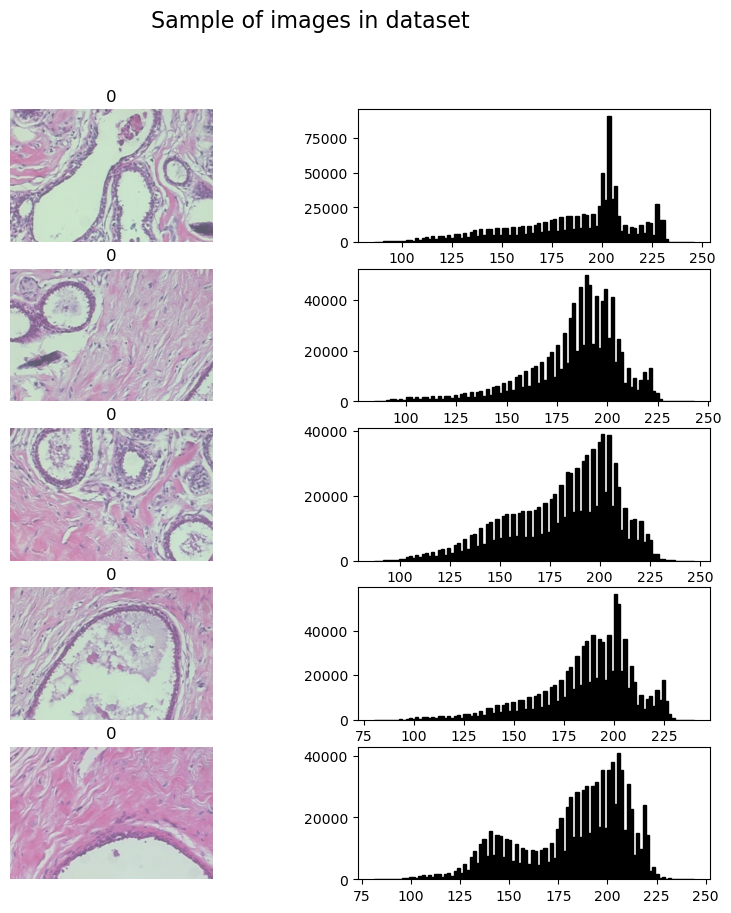

In [33]:
plot_images_with_histogram(images_base, nrows = len(images_base))

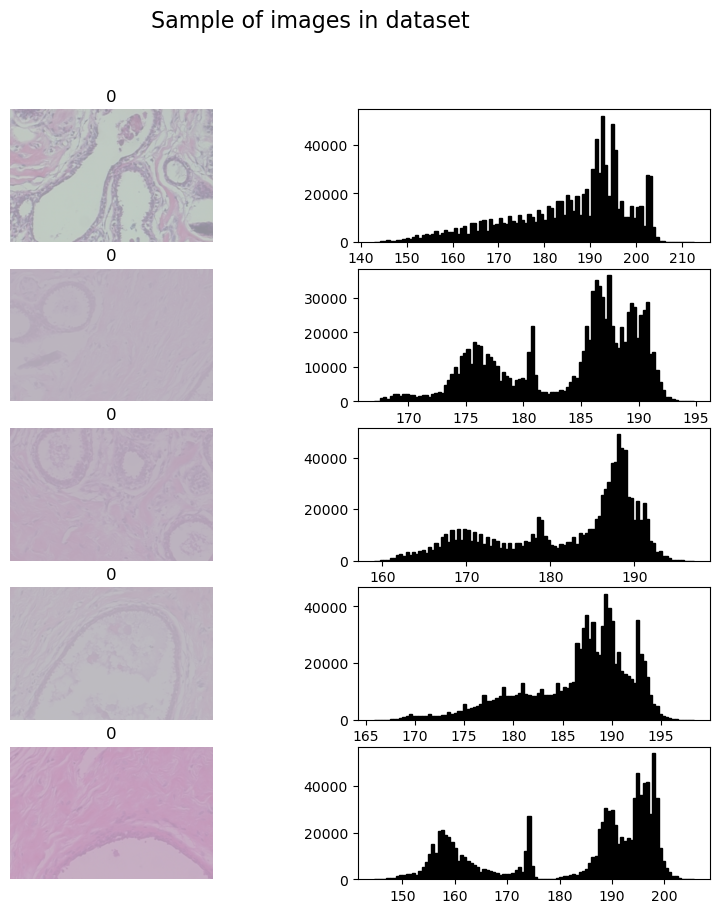

In [34]:
# Contrast
ds_temp = ds.map(read_image).map(augment_contrast)
images_contrast = create_image_set(ds_temp, 5)

## create general view of images
# plot_images(images_contrast, nrows = len(images_contrast))
plot_images_with_histogram(images_contrast, nrows = len(images_contrast))

We can have an unequal distribution of pixels due to the sectioning of the tissue

Can we normalize the contrast and pixel intensities found in the images? 

### Edges Investigation

In [35]:
# grad_components = tf.image.sobel_edges(img)

# Model Creation

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

## Train, test split

More info on splitting data in [tensorflow](https://www.tensorflow.org/datasets/splits)

In [37]:
DATASET_SIZE = ds.cardinality().numpy()

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.10 * DATASET_SIZE)
test_size = int(0.20 * DATASET_SIZE)

ds = ds.shuffle(buffer_size= DATASET_SIZE)
train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

5536
1583
1581


In [38]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(read_image, num_parallel_calls=AUTOTUNE)

test_ds = test_ds.map(read_image,  num_parallel_calls=AUTOTUNE)

val_ds = val_ds.map(read_image,  num_parallel_calls=AUTOTUNE)

In [39]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(460, 700, 3)
(8,)


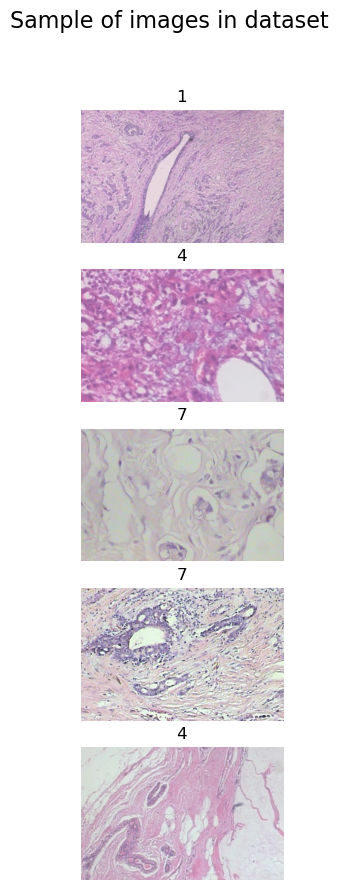

In [40]:
train_sample = create_image_set(train_ds, 5)
plot_images(train_sample, nrows=len(train_sample))

Configuring for performance

To train a model with this dataset you will want the data:
- To be well shuffled.
- To be batched.
- Batches to be available as soon as possible.

https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data

In [41]:
batch_size = 32

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Building the model

In [42]:
# Create a checkpoint directory to store the checkpoints.
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [44]:
num_classes = 8

model = tf.keras.Sequential([
  tf.keras.layers.Input((460, 700, 3)),
  tf.keras.layers.Conv2D(16, 3, activation='relu'), # same as kernel size of (3,3)
  tf.keras.layers.MaxPooling2D(),
  # tf.keras.layers.Conv2D(32, 3, activation='relu'),
  # tf.keras.layers.MaxPooling2D(),
  # tf.keras.layers.Conv2D(32, 3, activation='relu'),
  # tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 458, 698, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 229, 349, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1278736)           0         
                                                                 
 dense (Dense)               (None, 128)               163678336 
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 163,679,816
Trainable params: 163,679,816
Non-trainable params: 0
__________________________________________

In [45]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

hist = model.fit(
  train_ds,
  verbose = 1,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
  7/173 [>.............................] - ETA: 4:52 - loss: 70.9188 - accuracy: 0.1830

InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\Users\nickl\anaconda3\envs\w281\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\nickl\anaconda3\envs\w281\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\nickl\AppData\Local\Temp\ipykernel_16328\169283637.py", line 6, in <module>
      hist = model.fit(
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Cannot batch tensors with different shapes in component 0. First element had shape [460,700,3] and element 11 had shape [456,700,3].
	 [[{{node IteratorGetNext}}]] [Op:__inference_train_function_905]

size of cancer cells and progress of patients
brightness contrast, window detection iding siz of window. same window to different resolution
- feature tracking with TF 
  - integrating into models, post model or pre-processing

- gray scale
- UMAP
- sharpening and contrast

In [ ]:
# Baseline TensorFlow model
def create_baseline_cnn(inputShape=(460, 700, 3)):
    # max_sequence_length, hidden_layers, filters, kernel_size, learning_rate, embedding_size - other parameters excluding for now
    
    """ 
    Creating baseline CNN for comparison
    """
    
    inputs = tf.keras.layers.Input(shape=inputShape, name="Input_Layer")

    # Add convolutional layers
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten the output from the convolutional layers
    x = tf.keras.layers.Flatten()(x)

    # Add dense layers for classification
    x = tf.keras.layers.Dense(units=128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(units=10, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:
baseModel = create_baseline_cnn()


# Paper Model: 
Input Layer: 
- some transformations such as mean-subtraction and feature scaling
- parameters are (32 x 32 or 64 x 64) and 3 channels for RGB

Convolution Layers:
- (kernels) are of size 5 × 5, the zero-padding is set to 2 and the stride is set to 1. 
- first two convolutional layers learn 32 filters, initialized from Gaussian Distribution with SD of 0.0001 and 0.01 respectively
- last layer learns 64 filters and intialized from Gaussian distribution with SD of 0.0001

Pooling Layers: 
- responsible for down sampling spatial dimension of input
- one after each convolution layer
- 3 x 3 receptive field with stride of 2 
- first uses max operation over receptive field and other two are average pooling

ReLU Layers: 
- Treating as a layer
- Given an input value x, the ReLU layer computes the neuron’s output f(x) as x if x > 0 and (α × x) if x <= 0. The parameter α specifies whether to leak the negative part by multiplying it with the slope value (0.01 or so) rather than setting it to 0.
- default α is 0. When not set, $f(x) = max(0,x)$ aka activation threshold at zero

Inner-product layers (fully connected layers): 
- input treated as vector and produce output in form of single vector
- two inner-product layers
- the last is a fully-connected output layer with softmax activation and depends on number of classes for classification problem 2 for binary classification


In [ ]:
inputShape = (32, 32, 3)

inputs = tf.keras.layers.Input(shape=inputShape, name="Input_Layer")

# Add convolutional layers
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(
    5, 5), strides=(1, 1), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the output from the convolutional layers
x = tf.keras.layers.Flatten()(x)

# Add dense layers for classification
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=10, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)


The main idea is to extract from the high resolution
images patches with sizes that are close to those of the CIFAR
dataset. Since we are dealing with textures, the main premise is
that these patches can contain enough information for training
a model, provided an appropriate set of patches is extracted
from each image. 

Two Strategies: 
1. 32 x 32 window with 50% overlap
2. 64 x 64 window with no overlap and random sampling on image

In [ ]:
learningRate = 1E-6


In [ ]:
momentumTerm = 0.9


In [ ]:
weightDecay = 4e-5


In [ ]:
iterations = 8e5


# Creating Model

In [ ]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the pixel values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu",
                           input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train the model
history = model.fit(x_train, y_train, epochs=10,
                    batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)


In [ ]:
# Define the callback to save the model weights
checkpoint_path = "model_checkpoint.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Train the model with the callback
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_callback]
)

# Load the best model weights from the checkpoint
model.load_weights(checkpoint_path)


# Model Performance


$\text{Patient Score} = \frac{N_{rec}}{N_p}$  

## Global Patient Recognition Rate
$\text{Patient Recognition Rate} = \frac{\Sigma Patient Score}{Total Number of Patients}$

$\text{Image Recognition Rate} = \frac{N_{rec}}{N_{all}}$ 


